### Visualising the outputs of the CNN layers
(This notebook borrows heavily from the tutorial on the [keras blog](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html) doing a very similar task, except that they are visualising vggnet, using random noise, whereas here I am using my own network with input images)

In [1]:
from scipy.misc import imsave
import numpy as np
import pickle
import time
import cv2
from keras.models import load_model
# from keras.applications import vgg16
from keras import backend as K
K.set_learning_phase(0)

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# load the pretrained multiscale model 
model = load_model('models/mscnn1.h5')

In [4]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [10]:
# these are the availbale layers
layer_dict

{'batch_normalization_1': <keras.layers.normalization.BatchNormalization at 0x1139cb438>,
 'batch_normalization_2': <keras.layers.normalization.BatchNormalization at 0x1139cba20>,
 'batch_normalization_3': <keras.layers.normalization.BatchNormalization at 0x1139cb780>,
 'batch_normalization_4': <keras.layers.normalization.BatchNormalization at 0x12010ce80>,
 'batch_normalization_5': <keras.layers.normalization.BatchNormalization at 0x12019bb70>,
 'batch_normalization_6': <keras.layers.normalization.BatchNormalization at 0x120c588d0>,
 'batch_normalization_7': <keras.layers.normalization.BatchNormalization at 0x120c584e0>,
 'concatenate_1': <keras.layers.merge.Concatenate at 0x120c58f98>,
 'dropout_1': <keras.layers.core.Dropout at 0x120c581d0>,
 'dropout_2': <keras.layers.core.Dropout at 0x120c582e8>,
 'fc1': <keras.layers.core.Dense at 0x120c58fd0>,
 'fc2': <keras.layers.core.Dense at 0x120c58390>,
 'final': <keras.layers.core.Dense at 0x120c587b8>,
 'flatten_1': <keras.layers.core.Fl

In [20]:
# and to summarize the layers
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
set1_conv1 (Conv2D)             (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 32)   128         set1_conv1[0][0]                 
__________________________________________________________________________________________________
set1_conv2 (Conv2D)             (None, 32, 32, 32)   9248        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [5]:
with open('./data/train.p', mode='rb') as f:
    train = pickle.load(f)
X_train, y_train = train['features'], train['labels']
X_subset = np.array([X_train[3000], X_train[20000]])

In [6]:
hist_norm_values = np.load('data/mean_hist_values.npy').item()

In [11]:
def histogramEqualisation(img):
    original_type = img.dtype
    if img.dtype != 'uint8':
        img = img.astype('uint8')
    img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    equalised = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    return equalised.astype(original_type)


def hist(X):
    out = []
    for i in range(len(X)):
        out.append(histogramEqualisation(X[i]))
    return np.array(out)

def normalise(x, min_x, max_x):
    return (x - min_x) / (max_x - min_x)

def tensor_normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [8]:
X_subset_hist_normed = normalise(hist(X_subset), hist_norm_values['min_hist_train'], hist_norm_values['max_hist_train'])

In [8]:
img_width = 32
img_height = 32

# the name of the layer we want to visualize
layer_name = 'set2_conv3'
filter_index = 0  

input_img_data = np.array([X_subset_hist_normed[0]])

input_img_data.shape

(1, 32, 32, 3)

In [10]:
# tf placeholder
input_img = model.input
input_img

<tf.Tensor 'input_1:0' shape=(?, 32, 32, 3) dtype=float32>

In [18]:
# an initial trial of hte process with 1 layer
kept_filters = []
layer_name = 'set1_conv2'



for filter_index in range(16):
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.
    input_img_data = np.array([X_subset_hist_normed[0]])

    # we run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()



Processing filter 0
Filter 0 processed in 0s
Processing filter 1
Filter 1 processed in 0s
Processing filter 2
Filter 2 processed in 0s
Processing filter 3
Filter 3 processed in 0s
Processing filter 4
Filter 4 processed in 0s
Processing filter 5
Filter 5 processed in 0s
Processing filter 6
Filter 6 processed in 0s
Processing filter 7
Filter 7 processed in 0s
Processing filter 8
Filter 8 processed in 0s
Processing filter 9
Filter 9 processed in 0s
Processing filter 10
Filter 10 processed in 0s
Processing filter 11
Filter 11 processed in 0s
Processing filter 12
Filter 12 processed in 0s
Processing filter 13
Filter 13 processed in 0s
Processing filter 14
Filter 14 processed in 0s
Processing filter 15
Filter 15 processed in 0s


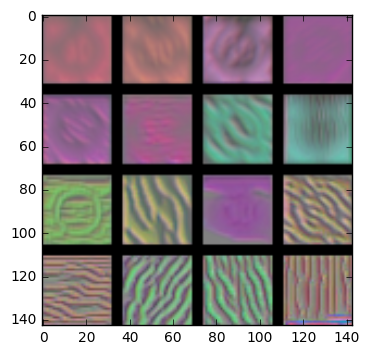

In [19]:
#  the filters with the highest loss/activations are those that are triggered the most
#  by the inputs, so display the top 16 filters
# stich the best 16 filters on a 4 x 4 grid.
n = 4

kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n]

# background
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                         (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img
plt.imshow(stitched_filters)

In [17]:
# let's wrap up the above in a function 
def gradient_processor(input_img_data, layer_name):
    for filter_index in range(20):

        # we build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        layer_output = layer_dict[layer_name].output
        loss = K.mean(layer_output[:, :, :, filter_index])

        # we compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, input_img)[0]

        # normalization trick: we normalize the gradient
        grads = tensor_normalize(grads)

        # this function returns the loss and grads given the input picture
        iterate = K.function([input_img], [loss, grads])

        # step size for gradient ascent
        step = 1.
#         input_img_data = np.copy(input_img)

        # we run gradient ascent for 20 steps
        for i in range(20):
            loss_value, grads_value = iterate([input_img_data])
            input_img_data += grads_value * step
            if loss_value <= 0.:
                # some filters get stuck to 0, we can skip them
                break

        # decode the resulting input image
        if loss_value > 0:
            img = deprocess_image(input_img_data[0])
            kept_filters.append((img, loss_value))
        
    return kept_filters

def visualiser(filters, n = 4):
        #  the filters with the highest loss/activations are those that are triggered the most
    #  by the inputs, so display the top 16 filters
    # stich the best 16 filters on a 4 x 4 grid.
    
    filters.sort(key=lambda x: x[1], reverse=True)
    filters = filters[:n * n]

    # background
    margin = 5
    width = n * img_width + (n - 1) * margin
    height = n * img_height + (n - 1) * margin
    stitched_filters = np.zeros((width, height, 3))

    # fill the picture with our saved filters
    for i in range(n):
        for j in range(n):
            img, loss = kept_filters[i * n + j]
            stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                             (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img
    plt.figure()
    plt.imshow(stitched_filters)
#     plt.imsave()
        

In [18]:
input_img_data = np.array([X_subset_hist_normed[0]])
layers_to_viz = ['set1_conv2']
for idx, name in enumerate(layers_to_viz):
    print(name)
    filters = gradient_processor(np.copy(input_img_data), name)
    visualiser(filters)

set1_conv2


NameError: name 'input_img' is not defined

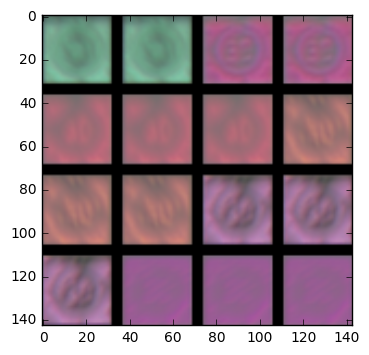

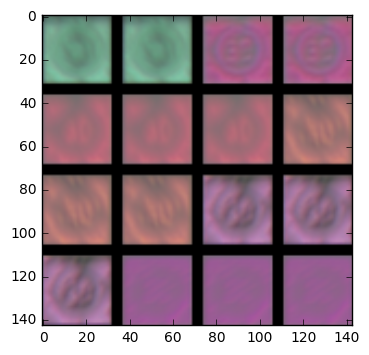

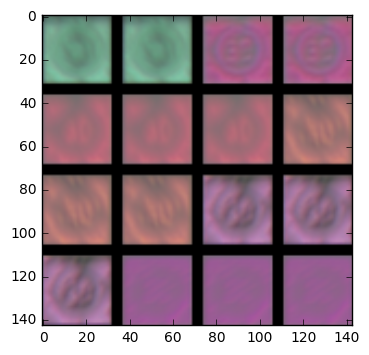

In [28]:
input_img_data = np.array([X_subset_hist_normed[0]])
layers_to_viz = ['set2_conv1', 'set2_conv2', 'set2_conv3']
for idx, name in enumerate(layers_to_viz):
    filters = gradient_processor(input_img_data, name)
    visualiser(filters)